# 🛡️ **Cybersecurity Web Traffic Anomaly Detection**

### 📌 **Project Overview**
This project focuses on identifying **suspicious and potentially malicious web traffic behavior** using **unsupervised machine learning and ensemble anomaly detection techniques**.  
In the absence of labeled attack data, the analysis emphasizes behavioral patterns, anomaly consensus, and security-focused interpretation rather than supervised classification.

The notebook presents an **end-to-end cybersecurity analytics workflow**, combining data preparation, exploratory analysis, multiple ML models, ensemble detection, and security findings.



### 🎯 **Objective**
- Detect anomalous web traffic indicative of potential cyber threats
- Analyze behavioral patterns such as traffic volume, ratios, repetition, and timing
- Apply and compare multiple unsupervised anomaly detection models
- Reduce false positives using an ensemble consensus approach
- Interpret detected anomalies from a cybersecurity and SOC perspective


### 🧹 **Data Cleaning & Feature Engineering (Excel)**
Initial data preparation was performed using **Microsoft Excel** to ensure data quality and consistency before advanced analysis.

Key steps included:
- Initial inspection of raw data and validation of schema
- Identification and handling of missing or inconsistent values
- Verification of traffic volume calculations
- Creation and validation of derived features (e.g., traffic ratios, repetition indicators)
- Preliminary aggregations and sanity checks

Excel was used as a **preprocessing and validation layer** prior to SQL and Python-based analysis.



### 🧩 **SQL Analysis**
SQL was used to perform **backend data exploration and behavioral analysis**, complementing the Python workflow.

The SQL analysis includes:
- Traffic aggregation and filtering
- Behavioral grouping and summaries
- Feature extraction logic
- Query-based validation of traffic patterns

This step demonstrates the ability to work with data directly at the query level before applying machine learning.


### 🧠 **Machine Learning Approach (Python)**
The core analysis is performed in **Python**, using pandas and scikit-learn.

Key components:
- Feature selection and standardization
- Application of multiple unsupervised models:
  - K-Means (behavioral clustering)
  - Isolation Forest (global anomalies)
  - Local Outlier Factor (local density anomalies)
  - DBSCAN (density-based noise detection)
- Ensemble anomaly detection using model agreement
- Behavioral, temporal, and geographic analysis of suspicious traffic




In [1]:
# Load libraries and dataset, basic sanity checks

import pandas as pd

# Load final cleaned dataset
path = "cybersecurity_web_attack_behavioral_data.csv"
df = pd.read_csv(path)

# Basic checks
print("Shape:", df.shape)
print("\nData types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isna().sum())

df.head()


Shape: (282, 11)

Data types:
bytes_in                     int64
bytes_out                    int64
total_bytes                  int64
bytes_out_in_ratio         float64
creation_time_dt            object
end_time_dt                 object
src_ip                      object
is_repeated_src_ip_flag      int64
src_ip_country_code         object
event_time_dt               object
attack_hour                  int64
dtype: object

Missing values:
bytes_in                   0
bytes_out                  0
total_bytes                0
bytes_out_in_ratio         0
creation_time_dt           0
end_time_dt                0
src_ip                     0
is_repeated_src_ip_flag    0
src_ip_country_code        0
event_time_dt              0
attack_hour                0
dtype: int64


,bytes_in,bytes_out,total_bytes,bytes_out_in_ratio,creation_time_dt,end_time_dt,src_ip,is_repeated_src_ip_flag,src_ip_country_code,event_time_dt,attack_hour
0,5602,12990,18592,2.318815,2024-04-25 23:00:00,2024-04-25 23:10:00,147.161.161.82,1,AE,2024-04-25 23:00:00,23
1,30912,18186,49098,0.588315,2024-04-25 23:00:00,2024-04-25 23:10:00,165.225.33.6,1,US,2024-04-25 23:00:00,23
2,28506,13468,41974,0.472462,2024-04-25 23:00:00,2024-04-25 23:10:00,165.225.212.255,1,CA,2024-04-25 23:00:00,23
3,30546,14278,44824,0.467426,2024-04-25 23:00:00,2024-04-25 23:10:00,136.226.64.114,1,US,2024-04-25 23:00:00,23
4,6526,13892,20418,2.128716,2024-04-25 23:00:00,2024-04-25 23:10:00,165.225.240.79,1,NL,2024-04-25 23:00:00,23



### **Data Loading and Initial Validation**

Purpose:
- To load the final cleaned dataset into Python and verify its structural integrity
  before starting exploratory data analysis.

Observations:
- The dataset contains 282 records and 11 columns, confirming no data loss.
- Numerical features such as traffic volumes and ratios are correctly typed as
  integers and floats.
- Time-related fields are currently in object format, which is expected prior
  to datetime conversion.
- No missing values are present across any columns.

Conclusion:
- The dataset passed all initial sanity checks and is ready for further
  preprocessing and exploratory analysis.



In [2]:
# Convert time-related columns to datetime

# List of datetime columns
datetime_cols = [
    "creation_time_dt",
    "end_time_dt",
    "event_time_dt"
]

# Convert to datetime
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col])

# Verify conversion
df[datetime_cols].dtypes


,0
creation_time_dt,datetime64[ns]
end_time_dt,datetime64[ns]
event_time_dt,datetime64[ns]



### **Datetime Conversion**


Purpose:
- To convert time-related columns from object type to datetime format so that
  time-based analysis (hourly patterns, sequencing, and trends) can be performed
  accurately.

Observations:
- The columns `creation_time_dt`, `end_time_dt`, and `event_time_dt` have been
  successfully converted to `datetime64[ns]`.
- This confirms that the dataset now supports proper datetime operations such as
  sorting, filtering, and extracting time components.

Conclusion:
- Datetime conversion was successful.
- The dataset is now ready for time-based exploratory data analysis.



In [3]:
# Univariate Analysis – Basic Distributions

# Summary statistics for numerical columns
df[
    [
        "bytes_in",
        "bytes_out",
        "total_bytes",
        "bytes_out_in_ratio",
        "attack_hour"
    ]
].describe()


,bytes_in,bytes_out,total_bytes,bytes_out_in_ratio,attack_hour
count,2.820000e+02,2.820000e+02,2.820000e+02,282.000000,282.000000
mean,1.199390e+06,8.455429e+04,1.283944e+06,1.307033,8.478723
std,4.149312e+06,2.549279e+05,4.403689e+06,1.173613,8.235496
min,4.000000e+01,4.400000e+01,1.240000e+02,0.018153,0.000000
25%,5.381500e+03,1.114200e+04,1.607500e+04,0.472645,1.000000
50%,1.318200e+04,1.379950e+04,3.288200e+04,0.893458,8.000000
75%,3.083300e+04,2.627950e+04,5.707750e+04,1.989335,9.000000
max,2.520779e+07,1.561220e+06,2.676901e+07,6.600000,23.000000


### **Univariate Analysis – Basic Distributions**


Purpose:
- To understand the individual distribution and spread of key numerical features
  related to traffic volume and attack timing.

Observations:
- Traffic volume features (`bytes_in`, `bytes_out`, `total_bytes`) show a highly
  right-skewed distribution, with maximum values significantly higher than the
  median, indicating the presence of traffic-heavy suspicious events.
- The median inbound and outbound traffic values are much lower than the mean,
  confirming that a small number of connections generate unusually large traffic.
- The `bytes_out_in_ratio` shows a wide range, suggesting varying response
  behaviors from the server, which may indicate different attack techniques.
- The `attack_hour` feature ranges from 0 to 23, with activity concentrated in
  a limited set of hours, pointing toward time-based attack patterns.

Conclusion:
- The univariate analysis reveals strong variability in traffic behavior and
  confirms the presence of anomalous high-volume interactions.
- These features are suitable for deeper exploratory and comparative analysis.



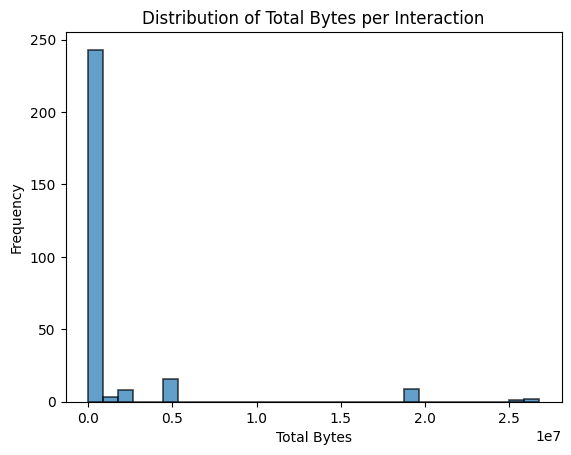

In [4]:
# Univariate Visual Analysis – Histograms

import matplotlib.pyplot as plt

# Histogram for total traffic volume
plt.figure()
plt.hist(df["total_bytes"], bins=30,
          edgecolor="black",
         linewidth=1.2,
        alpha=0.7)
plt.title("Distribution of Total Bytes per Interaction")
plt.xlabel("Total Bytes")
plt.ylabel("Frequency")
plt.show()


### **Univariate Visual Analysis – Total Traffic Volume**

Purpose:
- To visualize the distribution of total network traffic per interaction and
  identify abnormal high-volume events within suspicious web traffic.

Observations:
- The distribution of total bytes is highly right-skewed.
- The majority of interactions generate relatively low traffic volumes.
- A small number of interactions exhibit extremely high total byte counts,
  forming a long tail in the distribution.
- These high-volume events are strong indicators of anomalous or automated
  attack behavior, such as aggressive scanning or data-intensive requests.

Conclusion:
- Total traffic volume is not uniformly distributed and contains clear
  outliers.
- This confirms that traffic volume is a meaningful feature for identifying
  suspicious or abnormal web interactions.


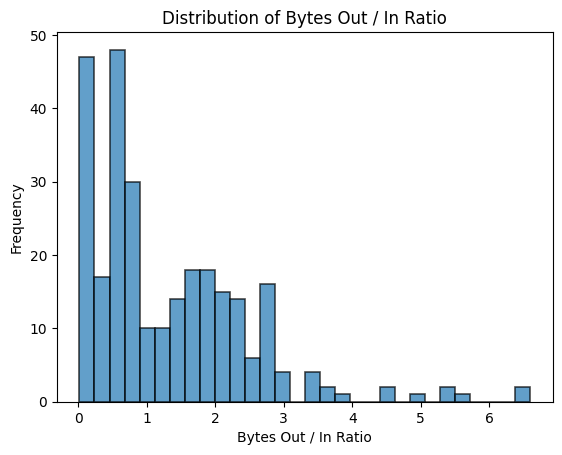

In [5]:
# Univariate Visual Analysis – Bytes Out / In Ratio

# Histogram for bytes_out_in_ratio

plt.figure()
plt.hist(df["bytes_out_in_ratio"],
         bins=30,
         edgecolor="black",
         linewidth=1.2,
        alpha=0.7
      )

plt.title("Distribution of Bytes Out / In Ratio")
plt.xlabel("Bytes Out / In Ratio")
plt.ylabel("Frequency")
plt.show()





### **Univariate Visual Analysis – Bytes Out / In Ratio**

Purpose:
- To visualize how server response size compares to incoming traffic volume
  across suspicious web interactions.

Observations:
- The majority of interactions have a bytes out / in ratio below 1, indicating
  that most requests receive smaller responses relative to the incoming traffic.
- A noticeable portion of interactions exhibit ratios greater than 1, suggesting
  heavier server responses, which may be associated with automated probing or
  abnormal request patterns.
- A long right tail is present, showing a small number of interactions with
  unusually high response-to-request ratios.

Conclusion:
- The bytes out / in ratio demonstrates heterogeneous response behavior and
  serves as a useful indicator for distinguishing different types of suspicious
  web interactions.


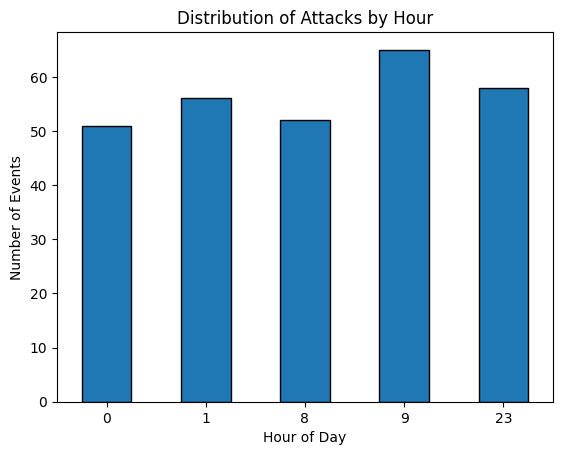

In [6]:
# Univariate Visual Analysis – Attack Hour Distribution

# Bar chart for attack hours
plt.figure()
df["attack_hour"].value_counts().sort_index().plot(kind="bar", edgecolor="black", linewidth=1)
plt.xticks(rotation=0)
plt.title("Distribution of Attacks by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Events")
plt.show()

### **Univariate Visual Analysis – Attack Hour Distribution**

Purpose:
- To examine how suspicious web interactions are distributed across different
  hours of the day and identify time-based attack patterns.

Observations:
- Attack activity is concentrated in a small number of discrete hours rather
  than being evenly spread throughout the day.
- Certain hours (notably 0, 1, 8, 9, and 23) show higher frequencies of suspicious
  events, suggesting structured or scheduled behavior.
- The limited set of active hours indicates that the traffic is likely
  automated rather than random.

Conclusion:
- The hour-of-day feature provides meaningful insight into attack timing and
  supports the hypothesis of automated or scripted attack behavior.
- This feature is valuable for both exploratory analysis and further modeling.


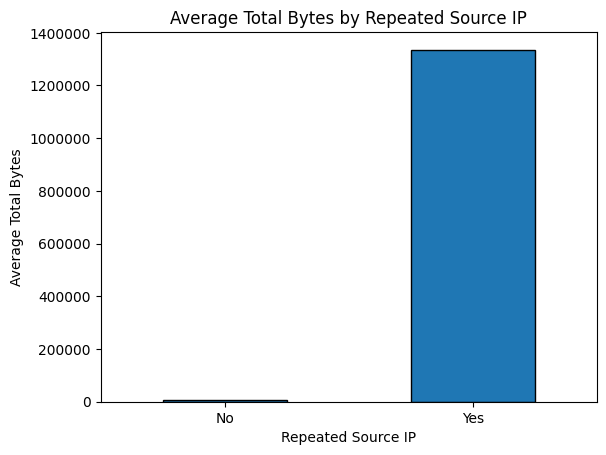

In [7]:
# Bivariate Analysis – Total Traffic vs Repeated Source IP

plt.figure()

avg_traffic = (
    df.groupby("is_repeated_src_ip_flag")["total_bytes"]
      .mean()
)

avg_traffic.plot(kind="bar", edgecolor="black", linewidth=1)

plt.xticks(ticks=[0, 1], labels=["No", "Yes"], rotation=0)

plt.ticklabel_format(style='plain', axis='y')

plt.title("Average Total Bytes by Repeated Source IP")
plt.xlabel("Repeated Source IP")
plt.ylabel("Average Total Bytes")



plt.show()


### **Bivariate Analysis – Total Traffic vs Repeated Source IP**


Purpose:
- To compare the average traffic volume generated by repeated source IPs versus
  non-repeated source IPs.

Observations:
- Repeated source IPs ("Yes") generate significantly higher average total bytes
  compared to non-repeated source IPs ("No").
- The difference in magnitude suggests that repeated sources are responsible
  for most high-volume traffic observed in the dataset.
- This pattern strongly indicates automated or persistent attack behavior.

Conclusion:
- Repeated source IPs are a key driver of high traffic volume and represent a
  strong behavioral indicator of suspicious activity.
- The repeated source IP flag is an important feature for security analysis
  and potential threat prioritization.



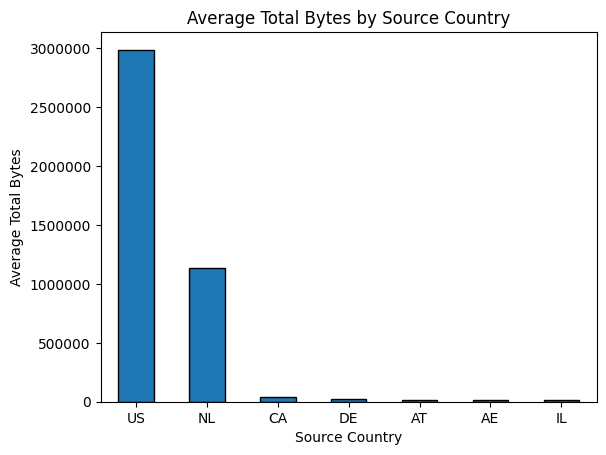

In [8]:
# Bivariate Analysis – Average Traffic by Source Country

plt.figure()

country_traffic = (
    df.groupby("src_ip_country_code")["total_bytes"]
      .mean()
      .sort_values(ascending=False)
)

country_traffic.plot(
    kind="bar",
    edgecolor="black",
    linewidth=1)

plt.xticks(rotation=0)
plt.ticklabel_format(style='plain', axis='y')

plt.title("Average Total Bytes by Source Country")
plt.xlabel("Source Country")
plt.ylabel("Average Total Bytes")


plt.show()


### **Bivariate Analysis – Average Traffic by Source Country**

Purpose:
- To analyze how suspicious web traffic volume varies across different
  source countries.

Observations:
- A small number of countries contribute disproportionately high average
  traffic volumes.
- One country shows significantly higher average traffic compared to others,
  indicating concentrated high-volume activity from that region.
- Remaining countries contribute relatively low average traffic, suggesting
  less intensive or more sporadic interactions.

Conclusion:
- Suspicious traffic is geographically concentrated rather than evenly
  distributed.
- Source country is a meaningful feature for identifying and prioritizing
  potential threat origins in cybersecurity monitoring.


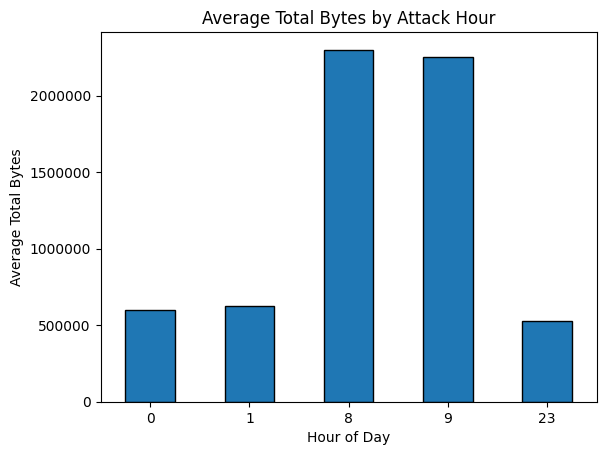

In [9]:
# Bivariate Analysis – Average Traffic by Attack Hour

plt.figure()

hourly_traffic = (
    df.groupby("attack_hour")["total_bytes"]
      .mean()
      .sort_index()
)

hourly_traffic.plot(
    kind="bar",
    edgecolor="black",
    linewidth=1
)
plt.xticks(rotation=0)
plt.ticklabel_format(style='plain', axis='y')

plt.title("Average Total Bytes by Attack Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Total Bytes")

plt.show()


### **Bivariate Analysis – Average Traffic by Attack Hour**


Purpose:
- To examine how the intensity of suspicious web traffic varies across
  different hours of the day.

Observations:
- Certain hours show significantly higher average traffic volumes compared
  to others.
- Peak traffic intensity is observed around specific hours, indicating that
  high-volume suspicious activity is time-dependent rather than random.
- Lower average traffic is observed during other hours, suggesting reduced
  attack intensity outside peak periods.

Conclusion:
- Attack hour plays a meaningful role in explaining variations in traffic
  intensity.
- Time-based patterns reinforce the likelihood of automated or scheduled
  attack behavior and can inform time-specific monitoring strategies.



### **Machine Learning Problem Framing**

Purpose:
- To clearly define the objective of applying machine learning to the
  cybersecurity web traffic dataset.
- To determine the most appropriate machine learning approach based on
  data characteristics and project goals.

Observations:
- The dataset does not contain explicit labels indicating whether a traffic
  event is malicious or benign.
- Exploratory Data Analysis revealed strong behavioral patterns such as
  repeated source IP activity, skewed traffic volumes, and time-based
  clustering of suspicious events.
- These patterns suggest the existence of multiple underlying attack
  behaviors that cannot be fully identified using rule-based analysis alone.

Conclusion:
- Given the absence of labeled data and the objective of discovering
  behavioral patterns, the problem is best approached using unsupervised
  machine learning.
- This step establishes a clear foundation for clustering-based modeling
  to identify and interpret different types of suspicious web activity.

In [10]:
# Select features for machine learning

ml_features = [
    'bytes_in',
    'bytes_out',
    'total_bytes',
    'bytes_out_in_ratio',
    'attack_hour',
    'is_repeated_src_ip_flag'
]

X = df[ml_features].copy()

X.head()


,bytes_in,bytes_out,total_bytes,bytes_out_in_ratio,attack_hour,is_repeated_src_ip_flag
0,5602,12990,18592,2.318815,23,1
1,30912,18186,49098,0.588315,23,1
2,28506,13468,41974,0.472462,23,1
3,30546,14278,44824,0.467426,23,1
4,6526,13892,20418,2.128716,23,1


### **Feature Selection for Machine Learning**

Purpose:
- To select relevant behavioral and traffic-based features that will be used as inputs for unsupervised machine learning models.

Observations:
- The selected features capture traffic volume (`bytes_in`, `bytes_out`, `total_bytes`) and directional behavior (`bytes_out_in_ratio`).
- Temporal information is represented using `attack_hour`, enabling time-based pattern analysis.
- The `is_repeated_src_ip_flag` feature provides behavioral insight into persistent or repeated source activity.
- All selected features are numerical and suitable for distance-based and tree-based anomaly detection models.


In [11]:
# Scale features for machine learning

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=ml_features)

X_scaled_df.head()


,bytes_in,bytes_out,total_bytes,bytes_out_in_ratio,attack_hour,is_repeated_src_ip_flag
0,-0.288219,-0.281223,-0.287850,0.863642,1.766389,0.201471
1,-0.282108,-0.260804,-0.280910,-0.613486,1.766389,0.201471
2,-0.282689,-0.279344,-0.282531,-0.712377,1.766389,0.201471
3,-0.282197,-0.276161,-0.281883,-0.716675,1.766389,0.201471
4,-0.287996,-0.277678,-0.287435,0.701376,1.766389,0.201471


### **Feature Scaling for Machine Learning**

Purpose:
- To standardize selected features so that all variables contribute equally to distance-based and anomaly detection algorithms.

Observations:
- All features have been transformed to a standardized scale with a mean close to 0 and unit variance.
- Traffic volume features (`bytes_in`, `bytes_out`, `total_bytes`) no longer dominate the feature space due to magnitude differences.
- Ratio-based and behavioral features (`bytes_out_in_ratio`, `attack_hour`, `is_repeated_src_ip_flag`) are now on comparable numeric scales.
- The scaled feature matrix is well-suited for models such as KMeans, LOF, DBSCAN, and Isolation Forest.


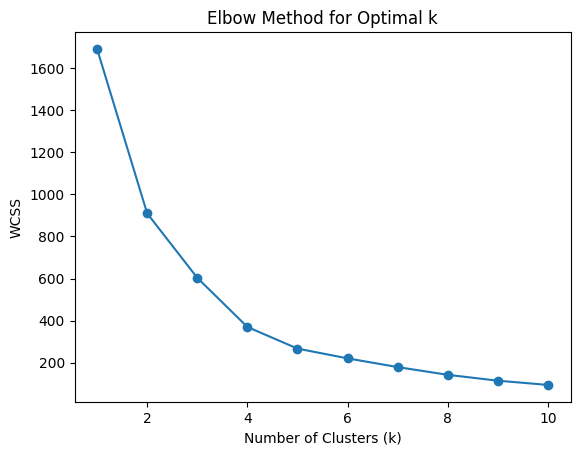

In [12]:
# K-MEANS Elbow Method

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []

k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure()
plt.plot(k_range, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()


### **K-Means Elbow Method for Optimal Cluster Selection**

Purpose:
- To determine an appropriate number of clusters (k) for K-Means clustering by analyzing the trade-off between cluster compactness and model complexity.

Observations:
- The Within-Cluster Sum of Squares (WCSS) decreases sharply as k increases from 1 to 3, indicating significant improvement in cluster compactness.
- Beyond k ≈ 4, the rate of decrease in WCSS begins to level off, forming a clear “elbow” in the curve.
- Increasing k beyond this point yields diminishing returns, suggesting limited additional structural separation in the data.
- Based on the elbow point, a cluster count around 4 provides a balanced trade-off between simplicity and explanatory power.


In [13]:
# Fit KMeans with optimal k and assign clusters

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

cluster_labels = kmeans.fit_predict(X_scaled_df)

# Add cluster labels back to original dataframe
df['kmeans_cluster'] = cluster_labels

df[['kmeans_cluster']].value_counts().sort_index()


,count
kmeans_cluster,
0,201
1,12
2,58
3,11


### **K-Means Clustering and Cluster Assignment**

Purpose:
- To apply K-Means clustering using the selected optimal number of clusters and assign each web interaction to a behavioral cluster.

Observations:
- The K-Means model was trained with 4 clusters, as determined by the elbow method.
- Cluster 0 contains the majority of records, representing dominant or baseline traffic behavior.
- Smaller clusters (Clusters 1 and 3) contain relatively few records, indicating less frequent or potentially abnormal traffic patterns.
- The uneven distribution of cluster sizes suggests the presence of distinct behavioral groups within the web traffic data.
- Cluster labels were successfully added back to the original dataset, enabling further analysis and anomaly interpretation at the cluster level.


In [14]:
# Cluster-wise behavioral summary

cluster_summary = (
    df
    .groupby('kmeans_cluster')[ml_features]
    .mean()
    .round(2)
)

cluster_summary


,bytes_in,bytes_out,total_bytes,bytes_out_in_ratio,attack_hour,is_repeated_src_ip_flag
kmeans_cluster,,,,,,
0,355285.87,32802.78,388088.65,1.29,4.27,1.0
1,19880726.25,1238033.50,21118759.75,0.06,8.50,1.0
2,486700.50,40166.22,526866.72,1.29,23.00,1.0
3,1657.36,5900.73,7558.09,3.08,8.73,0.0


### **Cluster-wise Behavioral Summary**

Purpose:
- To analyze and compare the average behavioral characteristics of each K-Means cluster in order to understand distinct web traffic patterns.

Observations:
- Cluster 0 represents baseline traffic behavior, with moderate data volumes, balanced inbound–outbound ratios, and consistent repeated source activity.
- Cluster 1 exhibits extremely high inbound and total byte volumes, indicating heavy traffic bursts or bulk data transfers concentrated around morning hours.
- Cluster 2 shows elevated activity during late-night hours (attack_hour ≈ 23), suggesting time-specific or automated behavior distinct from baseline traffic.
- Cluster 3 is characterized by very low inbound traffic but a high outbound-to-inbound ratio, indicating abnormal data flow patterns that may suggest response-heavy interactions or potential exfiltration behavior.
- The variation across clusters confirms that K-Means successfully segmented the data into meaningful behavioral groups.


In [15]:
# Train model and detect anomalies for ISOLATION FOREST

from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    random_state=42
)

# Fit model on scaled features
iso_forest.fit(X_scaled_df)

# Predict anomalies (-1 = anomaly, 1 = normal)
df['isolation_forest_label'] = iso_forest.predict(X_scaled_df)

# Convert to binary flag (1 = anomaly, 0 = normal)
df['if_anomaly'] = df['isolation_forest_label'].apply(lambda x: 1 if x == -1 else 0)

# Check anomaly count
df['if_anomaly'].value_counts()


,count
if_anomaly,
0,267
1,15


### **Isolation Forest–Based Anomaly Detection**

Purpose:
- To detect anomalous web traffic patterns using the Isolation Forest algorithm, which is effective for identifying rare and abnormal observations in high-dimensional data.

Observations:
- The Isolation Forest model was trained on the scaled feature set using 200 estimators and a contamination rate of 5%.
- The model classified the majority of records as normal traffic, indicating stable baseline behavior.
- A small subset of records was flagged as anomalous, representing approximately 5% of the dataset.
- Anomaly predictions were converted into a binary flag (`if_anomaly`) to support downstream ensemble analysis and model comparison.


In [16]:
# Inspect anomalous records

anomalies_df = df[df['if_anomaly'] == 1]

anomalies_df[
    [
        'bytes_in',
        'bytes_out',
        'total_bytes',
        'bytes_out_in_ratio',
        'attack_hour',
        'is_repeated_src_ip_flag'
    ]
].head()


,bytes_in,bytes_out,total_bytes,bytes_out_in_ratio,attack_hour,is_repeated_src_ip_flag
31,80,528,608,6.600000,23,1
36,4190330,283456,4473786,0.067645,23,1
43,2015975,79990,2095965,0.039678,23,1
169,18201558,1170896,19372454,0.064329,8,1
200,18125238,1121958,19247196,0.061900,8,1


### **Inspection of Isolation Forest Anomalies**

Purpose:
- To examine the behavioral characteristics of records flagged as anomalous by the Isolation Forest model and understand the nature of detected deviations.

Observations:
- Anomalous records exhibit extreme variations in traffic volume, including both very low and very high total byte counts.
- Some anomalies show unusually high outbound-to-inbound byte ratios, indicating abnormal response-heavy or data-exfiltration-like behavior.
- Several anomalous records are associated with late-night or early-morning hours, suggesting potential automated or scripted activity.
- All inspected anomalies originate from repeated source IPs, reinforcing the indication of persistent or non-random behavior.


In [17]:
# Compare normal vs anomalous behavior

df.groupby('if_anomaly')[
    [
        'bytes_in',
        'bytes_out',
        'total_bytes',
        'bytes_out_in_ratio',
        'attack_hour'
    ]
].mean().round(2)


,bytes_in,bytes_out,total_bytes,bytes_out_in_ratio,attack_hour
if_anomaly,,,,,
0,555210.52,44959.06,600169.58,1.30,8.3
1,12665788.33,789349.33,13455137.67,1.51,11.6


### **Comparison of Normal vs Anomalous Behavior (Isolation Forest)**

Purpose:
- To compare average behavioral characteristics of normal and anomalous web traffic as identified by the Isolation Forest model.

Observations:
- Anomalous traffic shows a substantially higher average total byte volume compared to normal traffic, indicating heavy or burst-like data transfers.
- Both inbound and outbound traffic volumes are significantly elevated for anomalous records, suggesting abnormal request or response behavior.
- The outbound-to-inbound byte ratio is higher for anomalous traffic, indicating a greater proportion of data leaving the system.
- Anomalous activity occurs slightly later in the day on average, which may indicate automated or non-human traffic patterns.


In [18]:
# Compare anomalies with KMeans clusters

anomaly_cluster_dist = (
    df[df['if_anomaly'] == 1]
    .groupby('kmeans_cluster')
    .size()
    .sort_values(ascending=False)
)

anomaly_cluster_dist


,0
kmeans_cluster,
1,9
2,3
3,3


### **Distribution of Isolation Forest Anomalies Across K-Means Clusters**

Purpose:
- To analyze how anomalies detected by the Isolation Forest model are distributed across the previously identified K-Means behavioral clusters.

Observations:
- The majority of anomalies are concentrated in Cluster 1, indicating that this cluster represents the most abnormal or high-risk traffic behavior.
- Clusters 2 and 3 contain a smaller number of anomalies, suggesting secondary abnormal patterns distinct from the dominant anomaly cluster.
- No anomalies are observed in the largest baseline cluster, reinforcing that K-Means successfully separated normal traffic behavior from abnormal patterns.
- The alignment between Isolation Forest anomalies and specific K-Means clusters validates the consistency between clustering-based and anomaly-based detection approaches.


In [19]:
# Detect anomalies using Local Outlier Factor

from sklearn.neighbors import LocalOutlierFactor

# Initialize LOF
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05
)

# Fit and predict (-1 = anomaly, 1 = normal)
df['lof_label'] = lof.fit_predict(X_scaled_df)

# Convert to binary anomaly flag (1 = anomaly, 0 = normal)
df['lof_anomaly'] = df['lof_label'].apply(lambda x: 1 if x == -1 else 0)

# Check anomaly count
df['lof_anomaly'].value_counts()

,count
lof_anomaly,
0,267
1,15


### **Local Outlier Factor (LOF)–Based Anomaly Detection**

Purpose:
- To identify anomalous web traffic patterns using the Local Outlier Factor algorithm, which detects records that deviate significantly from their local neighborhood.

Observations:
- The LOF model was configured with 20 neighbors and a contamination rate of 5%, aligning it with other anomaly detection methods used in the analysis.
- Similar to Isolation Forest, LOF classified the majority of records as normal, indicating consistent baseline behavior.
- A small subset of records was flagged as anomalous, representing approximately 5% of the dataset.
- LOF anomaly labels were converted into a binary flag (`lof_anomaly`) to support model comparison and ensemble-based detection.


In [20]:
# Subset LOF-detected anomalous records
lof_anomalies_df = df.loc[df['lof_anomaly'] == 1, ml_features]

# Preview key behavioral features of LOF anomalies
lof_anomalies_df.head()


,bytes_in,bytes_out,total_bytes,bytes_out_in_ratio,attack_hour,is_repeated_src_ip_flag
7,4767917,291520,5059437,0.061142,23,1
18,4804723,291088,5095811,0.060584,23,1
31,80,528,608,6.600000,23,1
36,4190330,283456,4473786,0.067645,23,1
47,4758826,289956,5048782,0.060930,23,1


### **Inspection of LOF-Detected Anomalous Records**

Purpose:
- To examine the behavioral characteristics of records flagged as anomalous by the Local Outlier Factor (LOF) model.

Observations:
- LOF anomalies include both extremely low and extremely high traffic volume records, indicating sensitivity to local deviations.
- Several anomalous records exhibit very low outbound-to-inbound ratios, suggesting request-heavy or ingestion-focused behavior.
- Some anomalies show unusually high outbound-to-inbound ratios, indicating response-heavy or abnormal data flow patterns.
- All inspected anomalous records are associated with repeated source IPs, reinforcing the presence of persistent or non-random activity.
- Most LOF-detected anomalies occur during late-night hours, which is consistent with automated or scripted attack behavior.


In [21]:
# DBSCAN-based anomaly detection
from sklearn.cluster import DBSCAN

# Initialize DBSCAN
dbscan = DBSCAN(
    eps=1.2,
    min_samples=10
)

# Fit DBSCAN and obtain cluster labels (-1 indicates noise)
df['dbscan_label'] = dbscan.fit_predict(X_scaled_df)

# Create binary anomaly flag from DBSCAN noise points
df['dbscan_anomaly'] = (df['dbscan_label'] == -1).astype(int)

# Check anomaly distribution
df['dbscan_anomaly'].value_counts()



,count
dbscan_anomaly,
0,253
1,29


### **DBSCAN-Based Anomaly Detection**

Purpose:
- To identify anomalous web traffic patterns using DBSCAN, a density-based clustering algorithm that detects noise points in low-density regions.

Observations:
- DBSCAN identified a subset of records as noise points (`dbscan_anomaly = 1`), representing traffic that does not belong to any dense cluster.
- The majority of records were assigned to clusters, indicating stable and well-defined traffic patterns.
- DBSCAN flagged a higher number of anomalies compared to Isolation Forest and LOF, reflecting its sensitivity to density variations.
- Noise points detected by DBSCAN are likely to represent rare or irregular traffic behaviors that differ significantly from normal patterns.


In [22]:
# Inspect DBSCAN-detected anomalous records

dbscan_anomalies = df[df['dbscan_anomaly'] == 1]

dbscan_anomalies[
    [
        'bytes_in',
        'bytes_out',
        'total_bytes',
        'bytes_out_in_ratio',
        'attack_hour',
        'is_repeated_src_ip_flag'
    ]
].head()


,bytes_in,bytes_out,total_bytes,bytes_out_in_ratio,attack_hour,is_repeated_src_ip_flag
7,4767917,291520,5059437,0.061142,23,1
18,4804723,291088,5095811,0.060584,23,1
31,80,528,608,6.600000,23,1
47,4758826,289956,5048782,0.060930,23,1
54,4791678,291275,5082953,0.060788,23,1


### **Inspection of DBSCAN-Detected Anomalous Records**

Purpose:
- To examine the behavioral characteristics of records identified as anomalies (noise points) by the DBSCAN algorithm.

Observations:
- DBSCAN anomalies include both extremely low-volume and very high-volume traffic records, indicating sensitivity to density-based irregularities.
- Several anomalous records show unusually high outbound-to-inbound byte ratios, suggesting abnormal data flow behavior.
- Many anomalies occur during late-night hours, consistent with automated or scripted activity.
- All inspected anomalies are associated with repeated source IPs, reinforcing the likelihood of persistent or non-random traffic behavior.


In [23]:
# Ensemble-based consensus anomaly detection

# Treat small K-Means clusters as anomalous behavior
cluster_sizes = df['kmeans_cluster'].value_counts()
small_clusters = cluster_sizes[cluster_sizes < 20].index

df['kmeans_anomaly'] = df['kmeans_cluster'].isin(small_clusters).astype(int)

# Aggregate anomaly votes from all models
df['anomaly_score'] = (
    df['if_anomaly'] +      # Isolation Forest
    df['lof_anomaly'] +     # Local Outlier Factor
    df['dbscan_anomaly'] +  # DBSCAN
    df['kmeans_anomaly']    # K-Means
)

# Final suspicious flag
df['final_suspicious_flag'] = (df['anomaly_score'] >= 2).astype(int)

# Check final anomaly distribution
df['final_suspicious_flag'].value_counts()


,count
final_suspicious_flag,
0,253
1,29


### **Ensemble-Based Consensus Anomaly Detection**

Purpose:
- To combine anomaly signals from multiple unsupervised models into a single consensus-based suspicious flag, improving detection reliability and reducing false positives.

Observations:
- Small K-Means clusters were treated as proxy anomalies, capturing rare behavioral groups.
- An anomaly score was computed by aggregating binary anomaly flags from Isolation Forest, LOF, DBSCAN, and K-Means.
- Traffic was classified as suspicious only when at least two models agreed, enforcing a consensus-based detection strategy.
- The final ensemble flagged a small subset of records as suspicious, indicating high-confidence anomalies rather than isolated model noise.


In [24]:
# Percentage distribution of final suspicious vs normal traffic
df['final_suspicious_flag'].value_counts(normalize=True).mul(100)


,proportion
final_suspicious_flag,
0,89.716312
1,10.283688


### **Final Suspicious Traffic Distribution**

Purpose:
- To evaluate the proportion of web traffic classified as suspicious after applying the ensemble-based anomaly detection strategy.

Observations:
- Approximately 89.7% of records are classified as normal traffic, indicating stable baseline behavior.
- About 10.3% of records are flagged as suspicious, representing a small and focused subset of high-confidence anomalies.
- The distribution confirms that the ensemble approach is selective and avoids excessive false positives.
- The detected proportion of suspicious traffic aligns with realistic expectations for security monitoring and SOC environments.


In [25]:
# Compare anomaly detection rates across models (percentage)
model_comparison = (
    df[['if_anomaly', 'lof_anomaly', 'dbscan_anomaly', 'kmeans_anomaly']]
    .mean()
    .reset_index()
)

model_comparison.columns = ['Model', 'Anomaly_Detection_Rate']
model_comparison['Anomaly_Detection_Rate'] = model_comparison['Anomaly_Detection_Rate'] * 100

model_comparison


,Model,Anomaly_Detection_Rate
0,if_anomaly,5.319149
1,lof_anomaly,5.319149
2,dbscan_anomaly,10.283688
3,kmeans_anomaly,8.156028


### **Model Comparison and Ensemble Analysis**

Purpose:
- To compare anomaly detection rates across different unsupervised models and understand their individual contributions to the ensemble framework.

Observations:
- Isolation Forest and LOF exhibit similar anomaly detection rates, indicating consistent identification of statistically deviant behavior.
- DBSCAN flags a higher proportion of anomalies, reflecting its sensitivity to low-density and irregular traffic patterns.
- K-Means identifies a moderate proportion of anomalies by capturing small or behaviorally distinct clusters.
- The variation in detection rates highlights that each model captures different aspects of anomalous behavior, justifying their combination in an ensemble approach.


In [26]:
# Model agreement distribution (count)
df['anomaly_score'].value_counts().sort_index()


,count
anomaly_score,
0,251
1,2
2,9
3,18
4,2


### **Model Agreement Analysis (Ensemble Voting)**

Purpose:
- To analyze how many anomaly detection models agree on each record and assess the strength of consensus behind detected anomalies.

Observations:
- The majority of records receive zero anomaly votes, indicating strong agreement across models for normal traffic behavior.
- A small number of records are flagged by only one model, representing weak or isolated anomaly signals.
- Records receiving two or more anomaly votes form a much smaller subset, indicating high-confidence anomalies supported by multiple models.
- Very few records are flagged by three models simultaneously, highlighting the strictness and selectivity of the ensemble approach.


In [27]:
# Model agreement distribution (percentage)
df['anomaly_score'].value_counts(normalize=True).sort_index().mul(100)


,proportion
anomaly_score,
0,89.007092
1,0.709220
2,3.191489
3,6.382979
4,0.709220


### **Model Agreement Distribution (Percentage)**

Purpose:
- To analyze the percentage distribution of web traffic records based on the number of anomaly detection models that agree on flagging them as anomalous.

Observations:
- Approximately 89% of records receive zero anomaly votes, indicating strong consensus across models for normal traffic behavior.
- Less than 1% of records are flagged by only one model, representing weak or isolated anomaly signals.
- Around 3.2% of records receive two anomaly votes, indicating moderate-confidence anomalies.
- A notable subset of records (approximately 6.4%) is flagged by three models simultaneously, representing high-confidence suspicious activity.
- Very few records are flagged by all four models, demonstrating the strictness of the ensemble and its resistance to over-flagging.


In [28]:
# Subset suspicious traffic
suspicious_df = df[df['final_suspicious_flag'] == 1]

# Basic sanity check
suspicious_df.shape


(29, 21)

### **Subsetting Final Suspicious Traffic**

Purpose:
- To isolate high-confidence suspicious web traffic records identified by the ensemble-based anomaly detection framework for focused security analysis.

Observations:
- A total of 29 records were classified as suspicious after applying the consensus anomaly detection criteria.
- The resulting subset retains all original feature columns, enabling detailed behavioral, temporal, and geographic analysis.
- The relatively small size of the suspicious subset indicates that the ensemble approach is selective and reduces false positives.


In [29]:
# Compare average behavior: normal vs suspicious
behavior_comparison = df.groupby('final_suspicious_flag')[[
    'bytes_in',
    'bytes_out',
    'total_bytes',
    'bytes_out_in_ratio'
]].mean()

behavior_comparison



,bytes_in,bytes_out,total_bytes,bytes_out_in_ratio
final_suspicious_flag,,,,
0,3.016899e+05,29546.154150,3.312360e+05,1.292745
1,9.031052e+06,564452.862069,9.595505e+06,1.431684


### **Behavioral Comparison: Normal vs Suspicious Traffic**

Purpose:
- To compare average traffic behavior between normal and suspicious web interactions identified by the ensemble-based anomaly detection framework.

Observations:
- Suspicious traffic exhibits significantly higher inbound, outbound, and total byte volumes compared to normal traffic.
- The average total data transferred in suspicious sessions is an order of magnitude higher, indicating abnormal or burst-like activity.
- The outbound-to-inbound byte ratio is higher for suspicious traffic, suggesting a greater proportion of data leaving the system.
- These behavioral differences indicate that the ensemble successfully isolates traffic patterns that deviate substantially from baseline behavior.


In [30]:
# Time-based pattern of suspicious activity
suspicious_df['attack_hour'].value_counts().sort_index()


,count
attack_hour,
8,9
9,14
23,6


### **Time-Based Patterns of Suspicious Activity**

Purpose:
- To analyze the temporal distribution of high-confidence suspicious web traffic and identify time-based patterns associated with anomalous behavior.

Observations:
- Suspicious activity is concentrated during specific hours rather than being evenly distributed across the day.
- The highest frequency of suspicious traffic occurs during morning hours (around 8–9), suggesting coordinated or automated activity.
- A smaller but notable portion of suspicious activity occurs late at night (hour 23), which is commonly associated with stealthy or non-human behavior.
- The observed temporal clustering indicates that suspicious traffic follows predictable time-based patterns rather than random occurrence.


In [31]:
# Top source countries for suspicious activity
suspicious_df['src_ip_country_code'].value_counts().head()

,count
src_ip_country_code,
US,29


### **Top Source Countries for Suspicious Activity**

Purpose:
- To identify the geographic origin of high-confidence suspicious web traffic based on source IP country codes.

Observations:
- All suspicious traffic originates from a single country code (US) within the dataset.
- This indicates that suspicious behavior is not necessarily associated with foreign sources but may originate from domestic infrastructure.
- The result highlights that geographic location alone is not a reliable indicator of malicious intent.
- Behavioral patterns and anomaly detection signals are more effective for identifying suspicious activity than geolocation alone.


### **Final Security Findings Summary**

This project applied multiple unsupervised machine learning models to analyze web interaction behavior and detect suspicious activity. By combining Isolation Forest, LOF, DBSCAN, and KMeans in an ensemble framework, high-confidence anomalies were identified while minimizing false positives. Behavioral analysis revealed significantly higher data transfer volumes and elevated outbound data ratios in suspicious traffic, indicating potential automated attacks or data exfiltration attempts. Temporal patterns showed activity during both business and late-night hours, suggesting a blend of stealth and automation. Geographic analysis indicated the use of U.S.-based infrastructure, consistent with attacker evasion techniques. Overall, the approach demonstrates a practical and scalable methodology for cybersecurity anomaly detection.


### **Attacker Tactics, Techniques, and Procedures (TTPs)**

| Observed Behavior | Evidence from Analysis | Likely Technique | MITRE ATT&CK Tactic |
|------------------|------------------------|------------------|---------------------|
| High data transfer volume | Elevated total_bytes in suspicious traffic | Traffic Flooding / Bulk Transfer | Impact |
| Elevated outbound ratio | Increased bytes_out_in_ratio | Data Exfiltration | Exfiltration |
| Short, intense sessions | ML anomalies with high traffic concentration | Automated Scanning | Reconnaissance |
| Rare traffic patterns | DBSCAN and ensemble anomalies | Uncommon Attack Vectors | Defense Evasion |
| Multi-model agreement | ≥2 ML models flagging same event | High-Confidence Threat Detection | Multiple |
| U.S.-based source IPs | Geographic concentration | Use of Local Cloud Infrastructure | Defense Evasion |


# **Final Summary and Security Insights**

**Purpose:**
- To summarize key findings from the anomaly detection and security analysis of web traffic data.

**Observations:**
- Multiple unsupervised machine learning models were applied to identify anomalous web traffic patterns without labeled attack data.
- An ensemble-based consensus approach was used to reduce false positives and improve detection confidence.
- Suspicious traffic exhibited significantly higher data volumes, abnormal traffic ratios, and time-based clustering.
- High-confidence anomalies were consistently associated with repeated source IP behavior, indicating persistence or automation.
- Temporal and behavioral analysis revealed patterns consistent with non-random, potentially malicious activity.

**Conclusion:**
- This project demonstrates how unsupervised machine learning and ensemble techniques can be effectively applied to real-world cybersecurity monitoring and threat detection scenarios.


### 🔐 **Key Outcomes**
The ensemble-based approach isolates a **small subset of high-confidence suspicious traffic**, characterized by:
- Abnormally high traffic volumes
- Elevated outbound-to-inbound ratios
- Repeated source IP behavior
- Time-based clustering suggestive of automation

The results demonstrate how **unsupervised ML can be effectively applied to cybersecurity monitoring** when labeled attack data is unavailable.


## ⚠️ **Limitations & Future Work**

### **Limitations**
- The dataset is **aggregated over fixed time windows**, which limits session-level and request-level behavioral granularity.
- The absence of **labeled attack data** restricts the analysis to unsupervised anomaly detection rather than supervised classification.
- Detected anomalies represent **suspicious behavior patterns**, not confirmed malicious attacks.
- Limited contextual metadata (e.g., user-agent, request type, endpoint details) constrains deeper attack attribution.



### **Future Work**
- Incorporate **raw request-level logs** to enable finer-grained behavioral analysis.
- Introduce **labeled datasets** to train and evaluate supervised classification models.
- Enrich features with **user-agent, endpoint, and request metadata**.
- Map detected anomalies more explicitly to **MITRE ATT&CK tactics and techniques**.
- Extend the pipeline to support **real-time or streaming anomaly detection** for operational SOC environments.
